In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad

In [3]:
print(sc.__version__)

1.10.4


In [2]:
meta_file = "/Users/kyu/Documents/rebecca_lab/public_data/belote_nature_2021/GSE151091_Metadata.csv"
count_file = "/Users/kyu/Documents/rebecca_lab/public_data/belote_nature_2021/GSE151091_raw_matrix.csv"

In [3]:
counts = pd.read_csv(count_file, index_col=0)  # Rows: Genes, Columns: Cells


In [4]:
counts.columns

Index(['A1015LM_D6_B003063', 'A1015LM_L19_B003063', 'A1015LM_I11_B003063',
       'A1015LM_K17_B003063', 'A1015LM_K15_B003063', 'A1015LM_D3_B003063',
       'A1015LM_O12_B003063', 'A1015LM_F16_B003063', 'A1015LM_F3_B003063',
       'A1015LM_O22_B003063',
       ...
       'A1046M_P7_B002549', 'A1046M_P7_B002550', 'A1046M_P8_B002522',
       'A1046M_P8_B002524', 'A1046M_P8_B002549', 'A1046M_P8_B002550',
       'A1046M_P9_B002522', 'A1046M_P9_B002524', 'A1046M_P9_B002549',
       'A1046M_P9_B002550'],
      dtype='object', length=14370)

In [5]:
meta = pd.read_csv(meta_file)
meta_with_heel_sole = meta.loc[meta.loc[:, "patient"].isin(meta.loc[meta.loc[:,"anatomical_location"].isin(["heel", "sole"]), "patient"].unique()),]
meta_with_heel_sole_mel = meta_with_heel_sole.loc[meta_with_heel_sole.loc[:, "class_1"] == "mel",]
meta_with_heel_sole_mel = meta_with_heel_sole_mel.set_index("cell_id")


In [6]:
meta_with_heel_sole_mel.loc[:,"cond"] = "other"
meta_with_heel_sole_mel.loc[:,"cond"][meta_with_heel_sole_mel.loc[:,"anatomical_location"].isin(["heel", "sole"])] = "sole_heel"

/var/folders/vf/n1ltdmj55nj1ms19mjqkx19m0000gn/T/ipykernel_9643/3092531614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_with_heel_sole_mel.loc[:,"cond"][meta_with_heel_sole_mel.loc[:,"anatomical_location"].isin(["heel", "sole"])] = "sole_heel"


In [7]:
meta_with_heel_sole_mel.index

Index(['12WKM01_E7_B001564', '12WKM01_C22_B001564', '12WKM01_D7_B001564',
       '12WKM01_E11_B001564', '12WKM01_I8_B001564', '12WKM01_H7_B001564',
       '12WKM01_E17_B001564', '12WKM01_E22_B001564', '12WKM01_H19_B001564',
       '12WKM01_P17_B001564',
       ...
       'A1046M_P6_B002549', 'A1046M_P6_B002550', 'A1046M_P7_B002522',
       'A1046M_P8_B002522', 'A1046M_P8_B002549', 'A1046M_P8_B002550',
       'A1046M_P9_B002522', 'A1046M_P9_B002524', 'A1046M_P9_B002549',
       'A1046M_P9_B002550'],
      dtype='object', name='cell_id', length=2912)

In [8]:
count_with_heel_sole_mel = counts.loc[:, meta_with_heel_sole_mel.index]

In [9]:
adata = ad.AnnData(X=count_with_heel_sole_mel.T)  # Transpose so cells are rows, genes are columns
adata.obs = meta_with_heel_sole_mel  # Add metadata as cell annotations
adata.var['gene_symbols'] = counts.index  # Add gene names as gene annotations

In [10]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.filter_genes(adata, min_cells=3)

In [11]:
adata.obs["patient"].unique()

array(['12WKM01', 'A1038LM', '12WK05', '18WKM06', 'A1046M'], dtype=object)

In [12]:
# Create a combined column for grouping
adata.obs["group"] = adata.obs["cond"] + "_" + adata.obs["patient"]

# Get unique groups
unique_groups = adata.obs["group"].unique()

# Aggregate counts for each group
count_data = []

for group in unique_groups:
    # Subset data for the group
    group_adata = adata[adata.obs["group"] == group]

    # Sum the counts for each gene
    group_counts = group_adata.X.sum(axis=0)


    count_data.append(group_counts)

# Create a count matrix
count_matrix = pd.DataFrame(
    np.vstack(count_data).T,  # Transpose to make genes rows and groups columns
    index=adata.var_names,    # Gene names as row index
    columns=unique_groups     # Group names as column names
)

# Display the count matrix
print(count_matrix)
count_matrix.to_csv("/Users/kyu/Documents/rebecca_lab/public_data/belote_nature_2021/pseudobulk.csv")

          other_12WKM01  other_A1038LM  sole_heel_A1038LM  sole_heel_12WKM01  \
A1BG               5403          19759               5486               3222   
A1BG-AS1           1588           3598                560               1115   
A1CF                  0              5                  0                  0   
A2M                   0           9722                997                901   
A2M-AS1               2           3090                 68                115   
...                 ...            ...                ...                ...   
ZYG11A                7              3                  0                  8   
ZYG11B            11411           3892               4357               6925   
ZYX               12990          11641               3301              10079   
ZZEF1              2824          11501              13533               3828   
ZZZ3               8029           6359               8458               3980   

          sole_heel_12WK05  other_12WK0

In [13]:
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

Number of cells: 2912
Number of genes: 21513


In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var['highly_variable']]

In [15]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution=0.5)

/Users/kyu/anaconda3/envs/py3/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/vf/n1ltdmj55nj1ms19mjqkx19m0000gn/T/ipykernel_9643/3964489640.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


In [16]:
sc.tl.umap(adata)

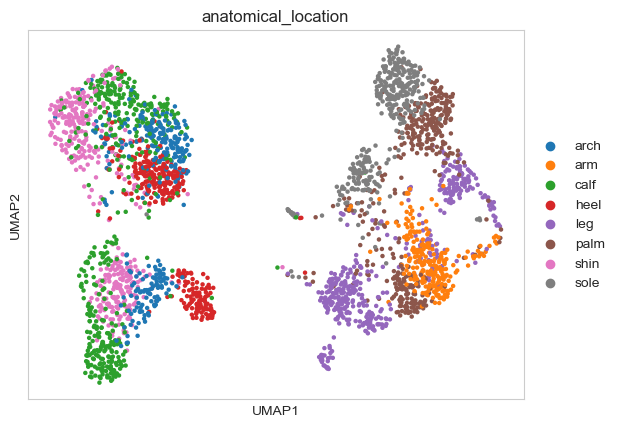

In [17]:
sc.pl.umap(adata, color='anatomical_location')


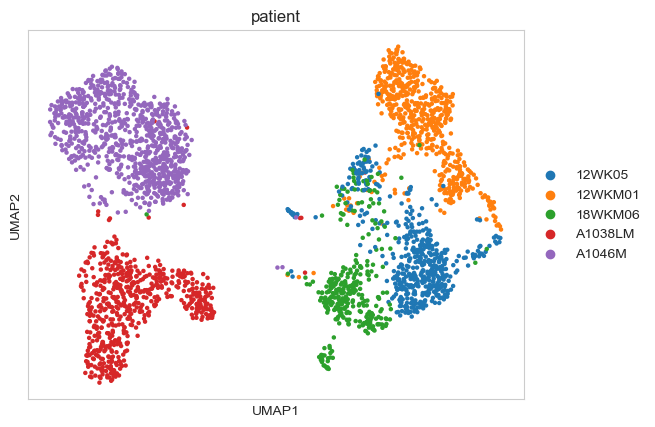

In [25]:
sc.pl.umap(adata, color='patient')

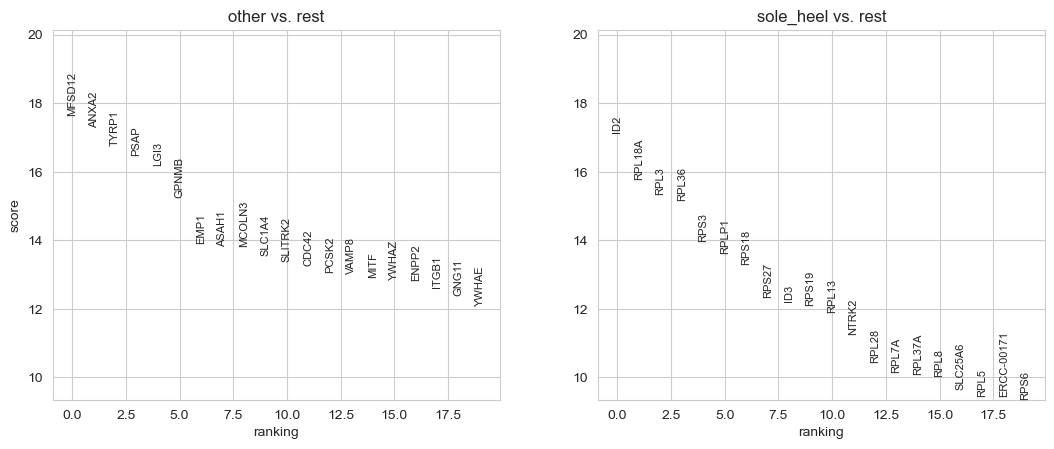

In [18]:

sc.tl.rank_genes_groups(adata, groupby='cond', method='wilcoxon', use_raw=True)
sc.pl.rank_genes_groups(adata)

In [103]:
adata.raw[:, "ID2"].X.flatten()

array([1.414136  , 0.71761453, 0.        , ..., 1.7586002 , 2.9135427 ,
       2.886593  ], dtype=float32)

In [19]:
result = adata.uns['rank_genes_groups']

# Extract data for condition_1 vs condition_2
de_table = pd.DataFrame({
    'gene': result['names']['sole_heel'],
    'logfoldchange': result['logfoldchanges']['sole_heel'],
    'pval': result['pvals']['sole_heel'],
    'pval_adj': result['pvals_adj']['sole_heel'],
    'scores': result['scores']['sole_heel']
})

# Display or save the results
print(de_table)
# de_table.to_csv("/Users/kyu/Documents/rebecca_lab/public_data/belote_nature_2021/deg_other_vs_sole_heel.csv", index=False)

         gene  logfoldchange          pval      pval_adj     scores
0         ID2       1.632801  6.002306e-66  4.304253e-62  17.152676
1      RPL18A       0.658705  4.832259e-56  1.485091e-52  15.772218
2        RPL3       0.531088  5.153216e-53  1.385764e-49  15.325655
3       RPL36       0.738413  7.640843e-52  1.643775e-48  15.149446
4        RPS3       0.548346  3.162262e-44  6.184521e-41  13.949634
...       ...            ...           ...           ...        ...
21508    LGI3      -2.171290  6.759225e-59  2.423520e-55 -16.181974
21509    PSAP      -1.322093  7.471299e-61  3.214601e-57 -16.456999
21510   TYRP1      -1.627792  4.590767e-63  2.469029e-59 -16.762480
21511   ANXA2      -0.861853  5.367535e-67  5.773589e-63 -17.292395
21512  MFSD12      -1.646832  1.157111e-69  2.489293e-65 -17.642740

[21513 rows x 5 columns]


In [122]:
# result = adata.uns['rank_genes_groups']
# 
# # Extract data for condition_1 vs condition_2
# de_table = pd.DataFrame({
#     'gene': result['names']['other'],
#     'logfoldchange': result['logfoldchanges']['other'],
#     'pval': result['pvals']['other'],
#     'pval_adj': result['pvals_adj']['other'],
#     'scores': result['scores']['other']
# })
# 
# # Display or save the results
# print(de_table)
# de_table.to_csv("/Users/kyu/Documents/rebecca_lab/public_data/belote_nature_2021/deg_other_vs_sole_heel.csv", index=False)

In [123]:
np.sign(de_table.loc[:, "logfoldchange"])

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
21508   -1.0
21509   -1.0
21510   -1.0
21511   -1.0
21512   -1.0
Name: logfoldchange, Length: 21513, dtype: float32

In [29]:

# de_table.loc[:, "metric"] = -np.log10(de_table.loc[:, "pval"]) / de_table.loc[:, "logfoldchange"]
de_table["metric"] = -np.log10(de_table["pval"]) * np.sign(de_table["logfoldchange"])



In [30]:
de_table

,gene,logfoldchange,pval,pval_adj,scores,metric
0,ID2,1.632801,6.002306e-66,4.304253e-62,17.152676,65.221682
1,RPL18A,0.658705,4.832259e-56,1.485091e-52,15.772218,55.315850
2,RPL3,0.531088,5.153216e-53,1.385764e-49,15.325655,52.287922
3,RPL36,0.738413,7.640843e-52,1.643775e-48,15.149446,51.116859
4,RPS3,0.548346,3.162262e-44,6.184521e-41,13.949634,43.500002
...,...,...,...,...,...,...
21508,LGI3,-2.171290,6.759225e-59,2.423520e-55,-16.181974,-58.170103
21509,PSAP,-1.322093,7.471299e-61,3.214601e-57,-16.456999,-60.126604
21510,TYRP1,-1.627792,4.590767e-63,2.469029e-59,-16.762480,-62.338115
21511,ANXA2,-0.861853,5.367535e-67,5.773589e-63,-17.292395,-66.270225


In [31]:
rnk = de_table.loc[:, ["gene", "metric"]]
rnk.to_csv("~/Documents/rebecca_lab/acral_melanoma/data/gsea/belote_other_vs_sole_heel.rnk", sep="\t", index=False, header=False, quoting=0)


In [20]:
print("Genes with all zeros:", (adata.X.sum(axis=0) == 0).sum())
print("Cells with all zeros:", (adata.X.sum(axis=1) == 0).sum())

Genes with all zeros: 0
Cells with all zeros: 0


In [21]:
gene_of_interest = "CRKL"

In [22]:
gene_expression = adata.raw[:, gene_of_interest].X.flatten()

In [23]:
# import re
# 
# pattern = "HOX"  # Example pattern to match genes starting with "Hoxa"
# matched_genes = [gene for gene in adata.raw.var_names if re.search(pattern, gene)]

In [24]:
p_value=de_table.loc[de_table.loc[:,"gene"] == gene_of_interest, "pval_adj"].values[0]

In [25]:
df = pd.DataFrame({
    "Expression": gene_expression,
    "Category": adata.obs["cond"]
})

df.to_csv(f"/Users/kyu/Documents/rebecca_lab/public_data/belote_nature_2021/{gene_of_interest}_exp_other_vs_sole_heel.csv", index=False)

In [26]:
# Can ignore this
# from scipy.stats import mannwhitneyu
# groups = df["Category"].unique()
# if len(groups) == 2:  # Ensure there are exactly two groups for the test
#     group1 = df[df["Category"] == groups[0]]["Expression"]
#     group2 = df[df["Category"] == groups[1]]["Expression"]
#     stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
#     print(f"Wilcoxon test: U-statistic={stat}, p-value={p_value}")
# else:
#     raise ValueError("Wilcoxon test requires exactly two groups for comparison.")


In [27]:
p_value

0.11973246899789934

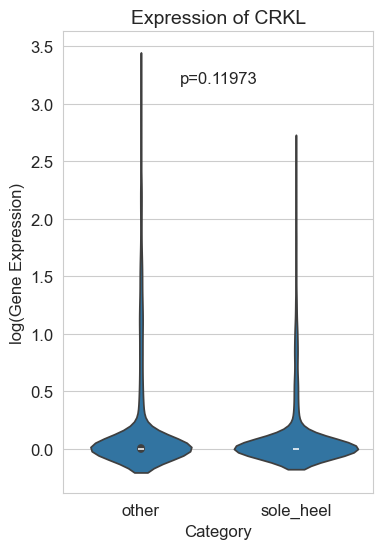

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 6))
sns.violinplot(data=df, x="Category", y="Expression")
sns.set_style("white")
# sns.stripplot(data=df, x="Category", y="Expression", color="black", alpha=0.5, jitter=True)
plt.text(0.5, max(df["Expression"]) * 0.98, f"p={p_value:.5f}", ha="center", fontsize=12)

plt.title(f"Expression of {gene_of_interest}", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("log(Gene Expression)", fontsize=12)
plt.xticks(fontsize=12)  # Control xtick size
plt.yticks(fontsize=12)  # Control ytick size
plt.savefig(f"/Users/kyu/Documents/rebecca_lab/public_data/belote_nature_2021/{gene_of_interest}_exp_other_vs_sole_heel.pdf", bbox_inches='tight')
plt.show()

In [148]:
df[df["Category"] == groups[1]].shape

(665, 2)